In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as ss
import warnings

from tqdm import tqdm,trange
from datetime import datetime

import sys
import importlib
sys.path.append('../d03_src/')
import vars
import utils
from utils import RMSE, diagonal, offdiagonal, flat, replace_infinite
from scipy.stats import pearsonr, spearmanr, linregress, sem
import process_infutor as pri
import process_census as prc
import optimization as opt
import evaluation as eval
import visualization as viz
import wildfires as wfr

import geopandas as gpd
from pygris.utils import shift_geometry, erase_water

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch, ConnectionPatch
from matplotlib.colors import TwoSlopeNorm,LogNorm,SymLogNorm
import matplotlib.lines as mlines
from matplotlib import colormaps as cm
import matplotlib.ticker as mticker
plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)

plots_dir = '../plots/'

# Analysis of Wildfires and Migration in California

In this notebook we analysis migration to and from the state of California alongside burn perimeters of wildfires in the state during 2010-2019.

## 1. Collecting the Data

Collect gdfs (in California):

In [2]:
gdf_dict = {'blockgroup': gpd.read_file(f'{vars._census_spatial_dir}processed/BLOCK_GROUP.gpkg'),
            'county': gpd.read_file(f'{vars._census_spatial_dir}processed/COUNTY.gpkg')}
california_gdf = {geography: _gdf[_gdf.STATE == '06'].reset_index().to_crs(vars._CA_crs) for geography,_gdf in gdf_dict.items()}

Collect membership matrices and indices:

In [3]:
_geographies = ['blockgroup', 'tract', 'county', 'state']
C_dict = {}
for fine_idx, fine_geography in enumerate(_geographies):
    for coarse_geography in _geographies[1+fine_idx:]:
        C_dict[(fine_geography, coarse_geography)] = prc.get_geography_matrices(fine_geography,
                                                                                coarse_geography,
                                                                                ignore_PR=True)

Collect the estimates:

In [4]:
M_dict = {year: ss.load_npz(f"{vars.MIGRATE_dir}{year}_{vars.MIGRATE_str}.npz") for year in trange(2011, 2020)}
for y, M in M_dict.items(): assert not (M < 0).nnz, f'Negative entries in {y} matrix'

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.73s/it]


Collect county-to-county and state-to-state flows (indexed by final year):

In [5]:
county_idx = prc.get_geography_indices('county', ignore_PR=True)
F_dict, Fhat_dict = {'state':{}, 'county':{}}, {'state':{}, 'county':{}}
for year in range(2011,2020):
    F_dict['state' ][year], Fhat_dict['state' ][year] = prc.get_ACS1_state_to_state(  year, ignore_PR=True)
    F_dict['county'][year], Fhat_dict['county'][year] = prc.get_ACS5_county_to_county(year, ignore_PR=True)

Collect population and demographics at the CBG level and county level:

In [6]:
Census_CBG = prc.get_census2010_CBG_demographics('Population', ignore_PR=True)

ACS_CBG_pop = prc.get_demographics(features=('Total', 'Population'), geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])
ACS_CBG_dem = prc.get_demographics(geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])

PEP_df = pd.read_csv(f'{vars._census_demographics_dir}processed/COUNTY_PEP.csv', index_col='GEOID')
PEP_df_ordered = PEP_df.loc[pd.Series(county_idx).sort_values().index]
PEP_COUNTY = {year: PEP_df_ordered[f'POPESTIMATE{year}'].values for year in range(2010,2020)}

### Fire Perimeter Data

The fire burn polygon comes from the [California Department of Forestry and Fire Protection](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters). We process them so that we have a burnt area for each CBG and county.

In [7]:
fires_gdf = wfr.get_fires_gdf(years=range(2010,2020))

How much of the state was hit?

In [8]:
fire_area_km2 = fires_gdf.dissolve().area.iloc[0]/1e6
cali_area_km2 = california_gdf['county'].dissolve().area.iloc[0]/1e6
print(f'There were {len(fires_gdf)} fires documented in California in 2010-2019.')
print(f'They assailed {int(fire_area_km2):,} squared km, {fire_area_km2/cali_area_km2:.1%} of state area.')

There were 3429 fires documented in California in 2010-2019.
They assailed 27,504 squared km, 6.5% of state area.


## 2. Mapping the Fires and Out-Migration:

In [9]:
vmax = 500
map_cmap = 'YlOrRd'

We will focus on the Camp and Tubbs fires (note that there are multiple fires labeled Camp Fire, but only one is the one we care about which is the one that burned the most area):

In [10]:
fires = [('Tubbs',   'October',   2017, ['Napa County', 'Sonoma County']),
         ('Camp',    'November',  2018, ['Butte County'])]

display(fires_gdf.loc[fires_gdf.name.isin([firename.upper() for firename, _, _, _ in fires])].sort_values(['name', 'year', 'acres']))

#Populate:
fire_perimeter, fire_CBGs, fire_counties_idx, CBG_idx_per_group = {}, {}, {}, {}
for fire_name, fire_month, fire_year, fire_counties in fires:
    fire_perimeter[fire_name], fire_CBGs[fire_name], CBG_idx_per_group[fire_name] = wfr.collect_fire_CBG_gdf(fire_name, fire_month, fire_year, fire_counties,
                                                                                                     all_fires_gdf=fires_gdf,
                                                                                                     california_gdf_dict=california_gdf,
                                                                                                     matrix_dictionary=M_dict)
    fire_counties_idx[fire_name] = california_gdf['county'].loc[california_gdf['county'].NAME.isin(fire_counties), 'index'].values

,year,name,cause,acres,days,geometry
797,2017.0,CAMP,9.0,253.936371,1.0,"MULTIPOLYGON (((-63697.438 -296801.853, -63753..."
718,2018.0,CAMP,11.0,13.535270,1.0,"MULTIPOLYGON (((-88446.305 -257177.813, -88446..."
335,2018.0,CAMP,11.0,153335.562500,18.0,"MULTIPOLYGON (((-141808.575 178057.983, -14181..."
963,2017.0,TUBBS,14.0,36701.984375,24.0,"MULTIPOLYGON (((-227094.324 73630.461, -226929..."


We generate a map of the fires and the outmigration (this is figure 4a):

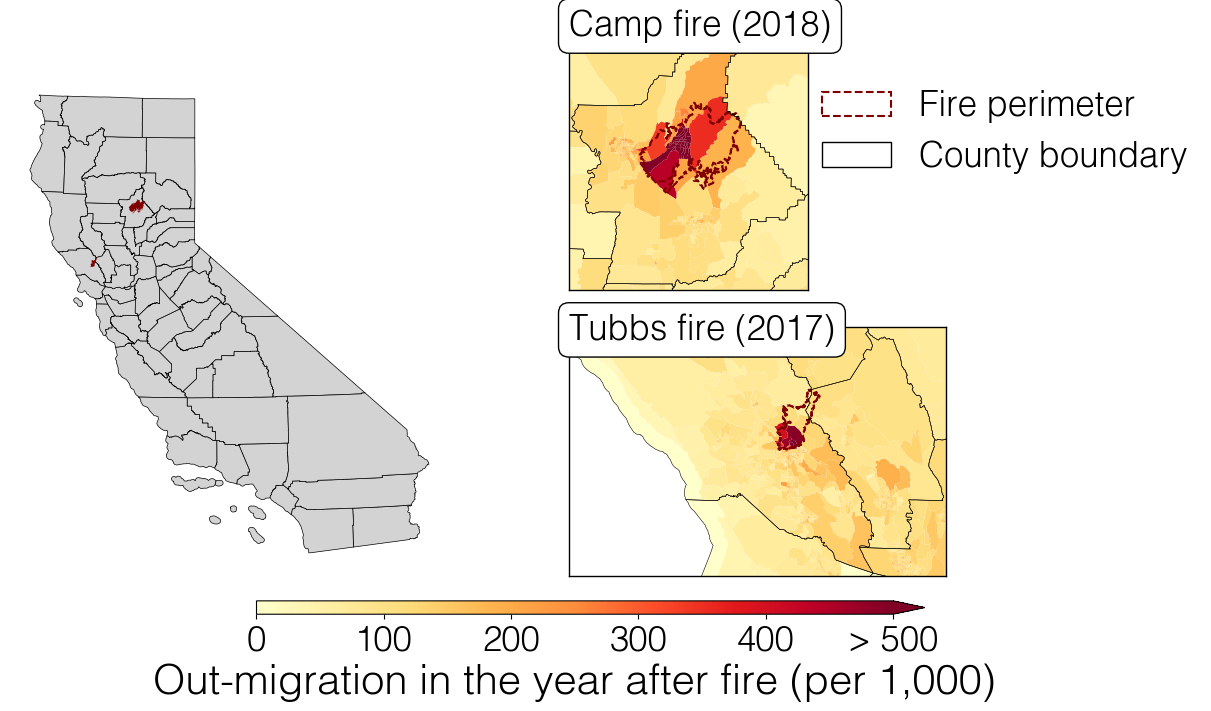

In [11]:
gs_kw = {'width_ratios':[.7, 1], 'height_ratios':[1, .93, .05], 'hspace':0.05, 'wspace':0.1} 
fig, Axes = plt.subplot_mosaic([['california',  'Camp'],
                                ['california',  'Tubbs'],
                                ['colorbar', 'colorbar']], gridspec_kw=gs_kw, figsize=(12, 7), layout='constrained')
for ax in Axes.values(): _ = ax.set_anchor('SW')
    
ax = Axes['california']
ax = viz.plot_california(california_gdf['county'], fires_gdf,
                         fire_perimeter=fire_perimeter, ax=ax)

for fire_name, fire_month, fire_year, fire_counties in fires:

    #Get bounds:
    bounds = california_gdf['county'][california_gdf['county'].NAME.isin(fire_counties)].dissolve().buffer(1_000).bounds.iloc[0]
    bounds = [bounds['minx'], bounds['miny'], bounds['maxx'], bounds['maxy']] 
    
    #Plot the fire:
    ax = Axes[fire_name]
    ax = viz.map_fire_migration(fire_CBGs[fire_name],
                                fire_name=fire_name, fire_year=fire_year,
                                base_map=california_gdf['county'],
                                fire_perimeter=fire_perimeter[fire_name],
                                cmap=map_cmap, bounds=bounds,
                                ax=ax, plot_colorbar=False, plot_legend=fire_name == 'Camp',
                                show=False, vmax=vmax,
                                show_name=True, per_thousand=True, outmover=True, textsize=25, title_fontsize=30,
                                legend_loc='upper left', legend_bbox=(1.,.8))

#Colorbar:
Axes['colorbar'] = viz.plot_colorbar(vmax, fig, Axes['colorbar'], cmap=map_cmap,
                                     title='Out-migration in the year after fire (per 1,000)',
                                     label_size=25, title_size=30)
#Save:
plt.savefig(f'{plots_dir}fires-map.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}fires-map.pdf', dpi=300, bbox_inches='tight')

Within county movers:

In [12]:
for fire_name, fire_month, fire_year, fire_counties in fires:
    fire_outpopulation = M_dict[fire_year+1][CBG_idx_per_group[fire_name]['CBGs within fire perimeter']]
    fire_stayers = fire_outpopulation[:,CBG_idx_per_group[fire_name]['CBGs within fire perimeter']].diagonal()
    fire_outmovers = np.array(fire_outpopulation.sum(axis=1)).flatten() - fire_stayers
    fire_ending_in_fire_counties = np.array((fire_outpopulation @ C_dict[('blockgroup', 'county')]).sum(axis=0)).flatten()[fire_counties_idx[fire_name]].sum()
    fire_movers_to_fire_counties = fire_ending_in_fire_counties - fire_stayers.sum()

    ratio_within_county = fire_movers_to_fire_counties/fire_outmovers.sum()

    print(f"{fire_name} fire: {ratio_within_county:.2%} of movers stayed within affected counties ({' + '.join(fire_counties)}).")

Tubbs fire: 77.14% of movers stayed within affected counties (Napa County + Sonoma County).
Camp fire: 53.85% of movers stayed within affected counties (Butte County).


## 3. Migration Time Series in Affected and Control CBGs:

We now look at the time series:


The year following Tubbs fire (2018), CBGs within fire perimeter had an out-migration rate:
...of 370.0 per 1,000 people
...about 1.06x that of 2017
...about 2.79x that of CBGs neighboring perimeter
...about 3.22x that of CBGs within affected counties
...about 3.28x that of CBGs in California

The year following Camp fire (2019), CBGs within fire perimeter had an out-migration rate:
...of 460.1 per 1,000 people
...about 2.40x that of 2018
...about 3.11x that of CBGs neighboring perimeter
...about 3.21x that of CBGs within affected counties
...about 4.35x that of CBGs in California


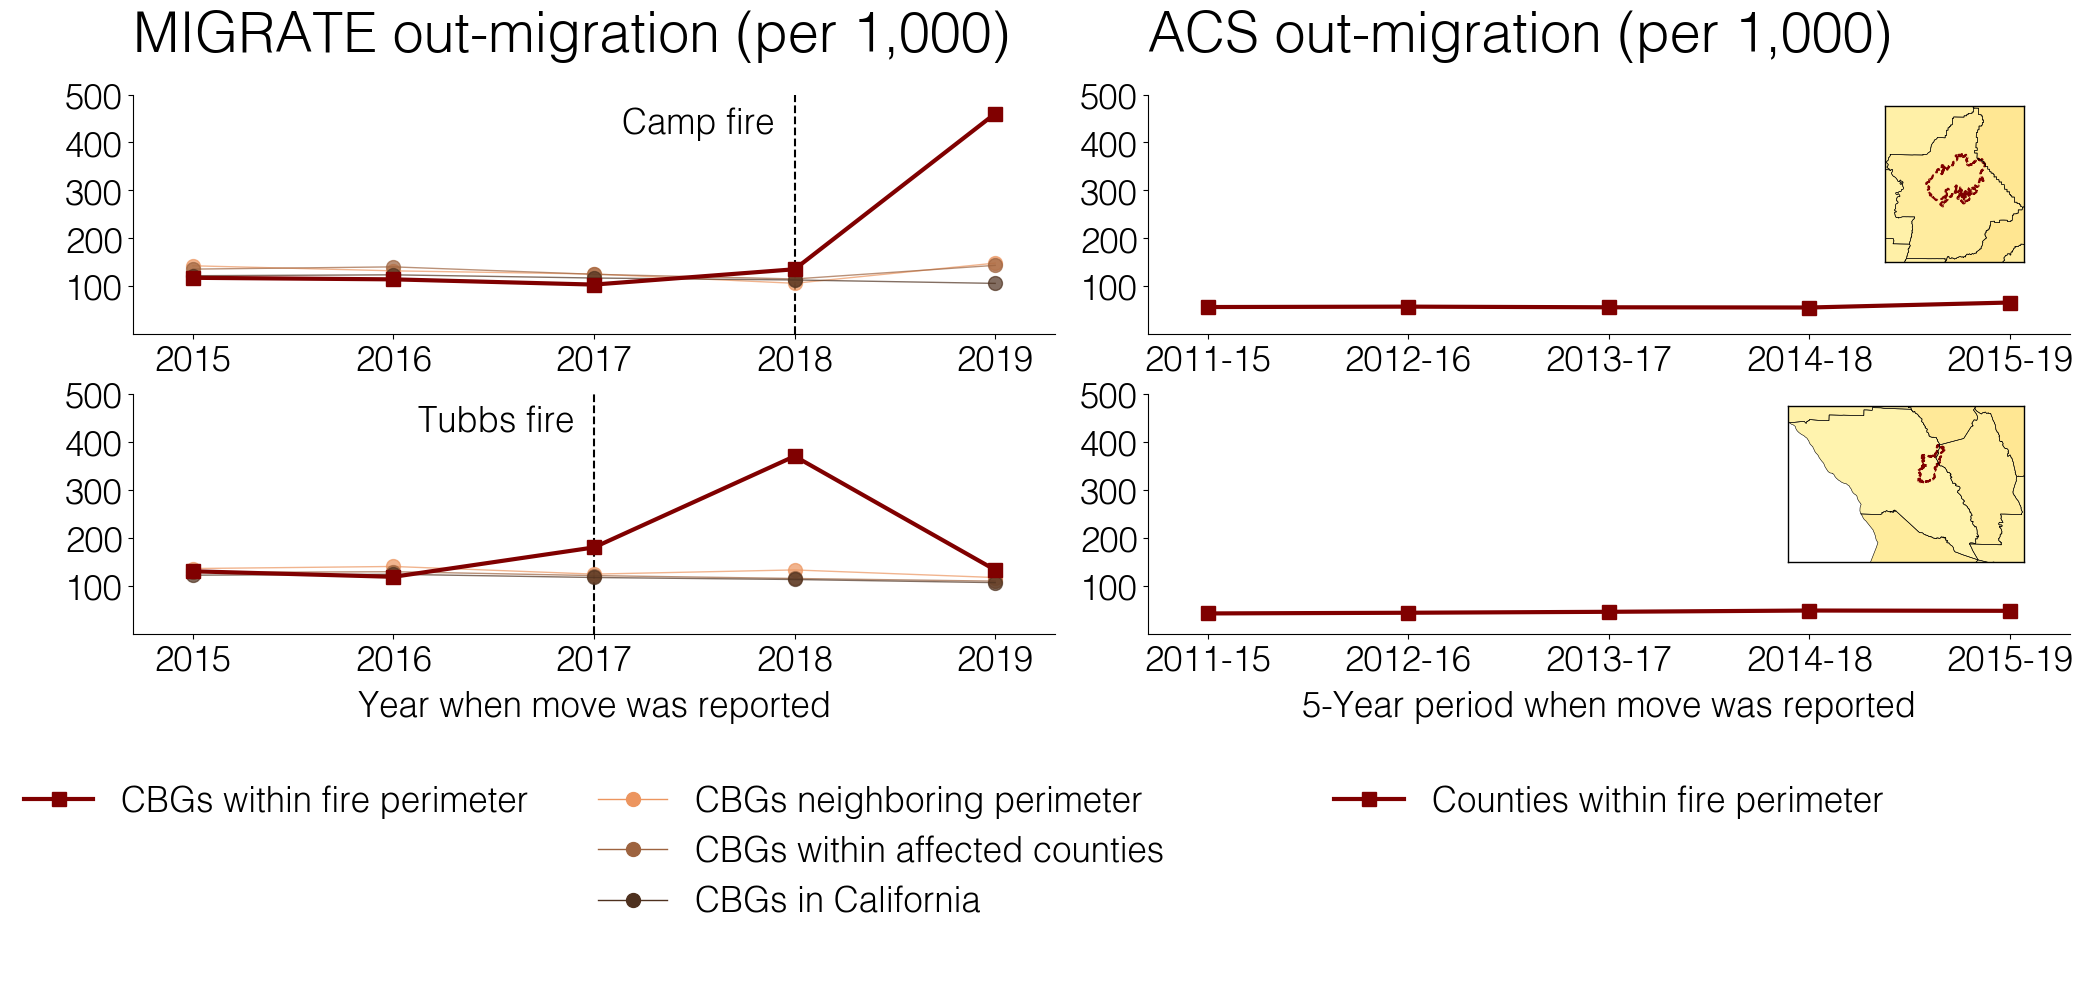

In [13]:
line_cmap='copper_r'
gs_kw = {'hspace':0.25, 'wspace':0.1} 
fig, Axes = plt.subplot_mosaic([['Camp', 'Camp_county' ],
                                ['Tubbs','Tubbs_county']],
                               gridspec_kw=gs_kw, figsize=(25, 7))
for ax in Axes.values(): _ = ax.set_anchor('SW')
    
for fire_name, fire_month, fire_year, fire_counties in fires:
    #Plot CBGs:
    Axes[fire_name] = viz.plot_fire_lines(CBG_idx_per_group[fire_name], M_dict,
                                                fire_name=fire_name, fire_year=fire_year,
                                                vmax=vmax, cmap=line_cmap, label_size=25,
                                                label_y=False, per_thousand=True,
                                                show_legend=True if fire_name=='Tubbs' else False,
                                                label_x=True if fire_name=='Tubbs' else False,
                                                outmover=True, passing_populations=False,
                                                ax=Axes[fire_name], verbose=True, tick_step=100,
                                                title_fontsize=40, title='MIGRATE out-migration (per 1,000)' if fire_name == 'Camp' else None,
                                                tick_size=25, two_column_legend=True)
    #Plot counties:
    gdf = california_gdf['county']
    affected_county_idx ={'Counties within fire perimeter': gdf[gdf.NAME.isin(fire_counties)]['index'].values}
    Axes[f'{fire_name}_county'] = viz.plot_fire_lines(affected_county_idx, F_dict['county'],
                                                         vmax=vmax, cmap=line_cmap, label_size=25,
                                                         label_y=False, per_thousand=True,
                                                         show_legend=True if fire_name=='Tubbs' else False,
                                                         five_year_data=True,
                                                         label_x=True if fire_name=='Tubbs' else False,
                                                         outmover=True, passing_populations=False,
                                                         ax=Axes[f'{fire_name}_county'], tick_step=100,
                                                         title_fontsize=40,
                                                         title='ACS out-migration (per 1,000)' if fire_name == 'Camp' else None,
                                                         tick_size=25)
    
    #Map counties:
    county_fire_gdf = wfr.include_outmigration(california_gdf['county'].copy(), flows=F_dict['county'][fire_year+1])
    inset_ax = Axes[f'{fire_name}_county'].inset_axes([.3, .3, .65, .65], transform=Axes[f'{fire_name}_county'].transAxes)
    _ = inset_ax.set_anchor('NE')
    inset_ax = viz.map_fire_migration(county_fire_gdf, fire_counties=fire_counties,
                                      base_map=california_gdf['county'],
                                      fire_perimeter=fire_perimeter[fire_name],
                                      cmap=map_cmap, vmax=vmax,
                                      plot_colorbar=False, plot_legend=False, show=False, ax=inset_ax)

#Save:
plt.savefig(f'{plots_dir}fires-lineplots.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}fires-lineplots.pdf', dpi=300, bbox_inches='tight')

### Looking at Population only



Tubbs


- Using MIGRATE:
CBGs within fire perimeter ['2015: 2.2', '2016: 3.0', '2017: -4.0', '2018: -25.2', '2019: 9.5']
CBGs neighboring perimeter ['2015: 2.3', '2016: -2.5', '2017: -1.0', '2018: -1.3', '2019: -1.2']
CBGs within affected counties ['2015: 0.0', '2016: -0.2', '2017: -0.2', '2018: 0.2', '2019: -1.3']
CBGs in California ['2015: -0.2', '2016: -0.3', '2017: -0.4', '2018: -0.4', '2019: -0.5']

- Using ACS 5-year:
CBGs within fire perimeter ['2015: 0.9', '2016: -1.4', '2017: 1.9', '2018: -7.1', '2019: -7.3']
CBGs neighboring perimeter ['2015: 3.6', '2016: 0.0', '2017: 0.8', '2018: -1.1', '2019: -0.0']
CBGs within affected counties ['2015: 0.7', '2016: 0.6', '2017: 0.5', '2018: 0.3', '2019: -0.1']
CBGs in California ['2015: 0.9', '2016: 0.6', '2017: 0.8', '2018: 0.4', '2019: 0.3']


Camp


- Using MIGRATE:
CBGs within fire perimeter ['2015: 2.2', '2016: 3.3', '2017: 3.6', '2018: -0.8', '2019: -20.4']
CBGs neighboring perimeter ['2015: -0.1', '2016: 1.3', '2017: 3.8', '2018: 

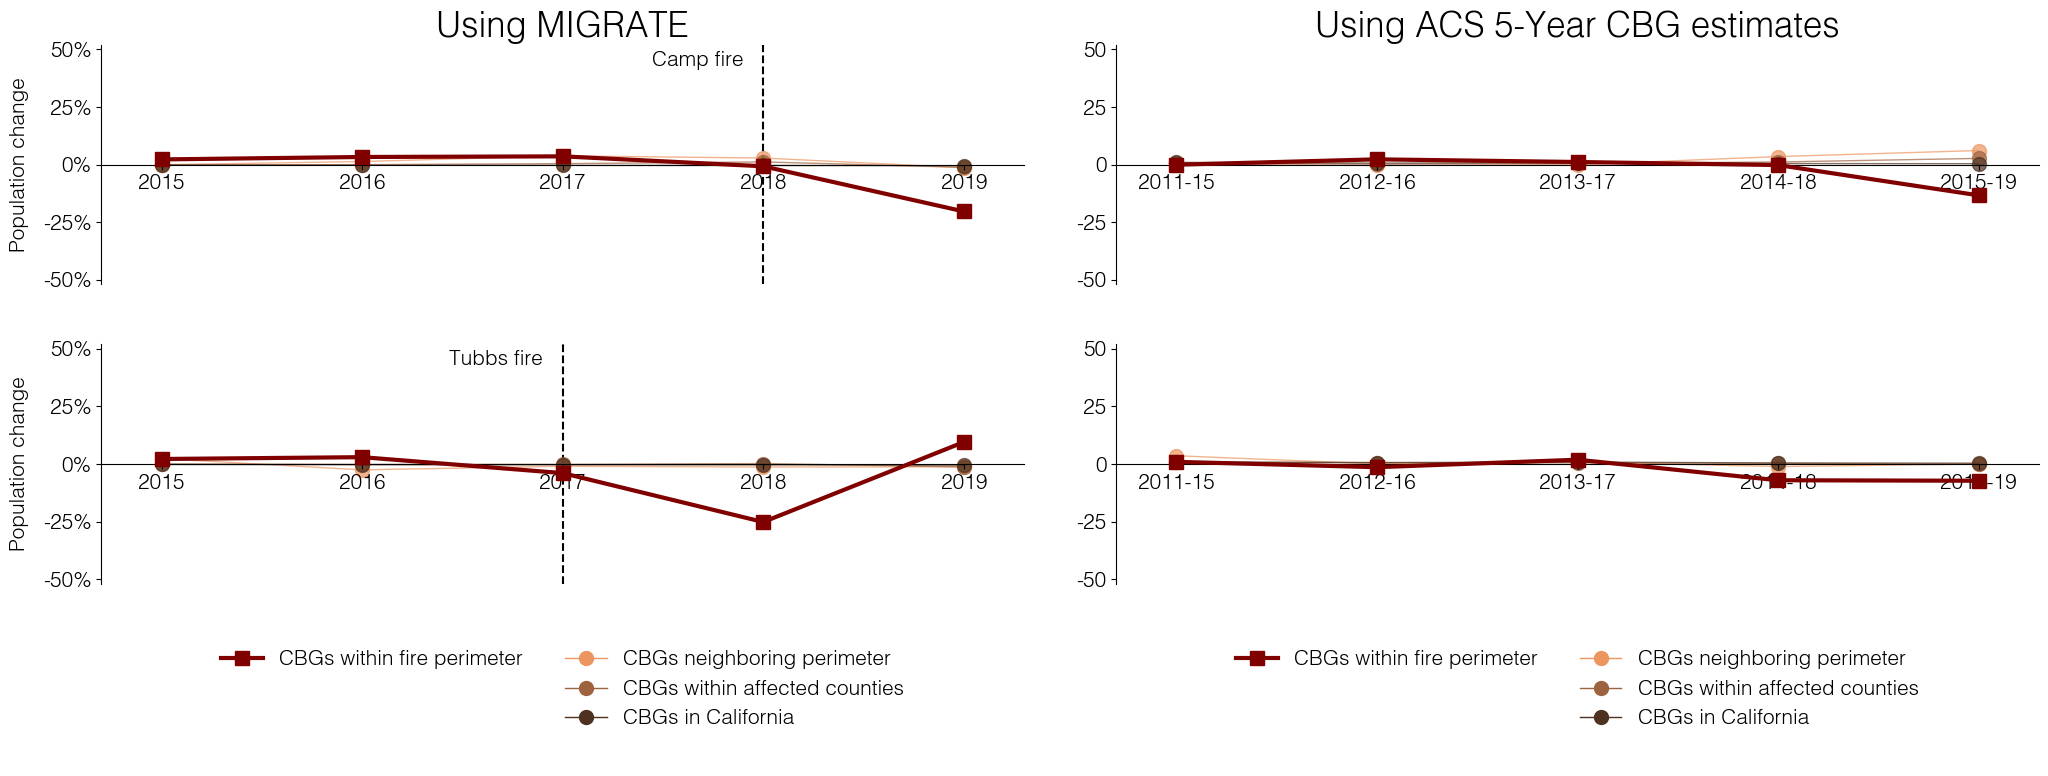

In [14]:
fig, Axes = plt.subplot_mosaic([['Camp', 'Camp_CBG'],
                                ['Tubbs','Tubbs_CBG']],
                               gridspec_kw=gs_kw, figsize=(25, 7))
for ax in Axes.values(): _ = ax.set_anchor('SW')
    
for fire_name, fire_month, fire_year, fire_counties in fires:
    print('\n')
    print(fire_name)
    print('\n')
    #Plot Migrate:
    print('- Using MIGRATE:')
    Axes[fire_name] = viz.plot_fire_lines(CBG_idx_per_group[fire_name], M_dict,
                                          fire_name=fire_name, fire_year=fire_year,
                                          vmax=52, cmap=line_cmap,
                                          label_y=True, per_thousand=False,
                                          show_legend=True if fire_name=='Tubbs' else False,
                                          label_x=False,#True if fire_name=='Tubbs' else False,
                                          outmover=False, passing_populations=False,
                                          ax=Axes[fire_name], verbose=False, print_values=True)
    #Plot ACS:
    print('\n- Using ACS 5-year:')
    Axes[f'{fire_name}_CBG'] = viz.plot_fire_lines(CBG_idx_per_group[fire_name], ACS_CBG_pop,
                                                   vmax=52, cmap=line_cmap,
                                                   label_y=False, per_thousand=False,
                                                   show_legend=True if fire_name=='Tubbs' else False,
                                                   label_x=False, five_year_data=True,
                                                   outmover=False, passing_populations=True,
                                                   ax=Axes[f'{fire_name}_CBG'], verbose=False, print_values=True)

#Configure:
_ = Axes['Camp'].set_title('Using MIGRATE', fontsize=25)
_ = Axes['Camp_CBG'].set_title('Using ACS 5-Year CBG estimates', fontsize=25)

#Save:
plt.savefig(f'{plots_dir}fires-popchange.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}fires-popchange.pdf', dpi=300, bbox_inches='tight')